In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as spo
import scipy.stats as sts
plt.style.use('seaborn')

# Pressure Analysis from the Ground Up
This notebook follows all the steps of the pressure data analysis from `Data_Analysis.ipynb` as transparently and simply as possible. The notebook will be written in an order following the conceptual steps in the analysis, rather than separating plots and code.

## Data Import
Data is imported from an HDF5 file which is created from ASCII in the `Import_Data.ipynb` notebook. Code is in place for future datasets to be labeled with a date string.

In [2]:
run_label = '2020_11_09' ## Change this to look at different runs
hdf_name = '{}_clean_data.h5'.format(run_label)

The HDF5 file stores data for each of the five gases with the name of the gas as the key. This notebook imports each table by key into a list of `pandas` tables by order of molecular weight.

|Index|Gas           |
|-----|--------------|
|0    |Hydrogen      |
|1    |Water Vapor   |
|2    |Nitrogen      |
|3    |Oxygen        |
|4    |Carbon Dioxide|

In [3]:
gases = ['H2', 'H2O', 'N2', 'O2', 'CO2']
gas_tables = [] # appendable list of gas data tables from HDF5

for gas in gases:
    gas_tables.append(pd.read_hdf(hdf_name, key=gas))

Checking the CO2 table:

In [4]:
gas_tables[4]

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp
1245126,0.0,7.660000e-07,293.5,293.4,293.45
3224153,41.0,7.640000e-07,293.5,293.4,293.45
2963520,83.0,7.720000e-07,293.5,293.4,293.45
748635,124.0,7.780000e-07,293.5,293.4,293.45
1839726,166.0,7.900000e-07,293.5,293.4,293.45
...,...,...,...,...,...
1775311,230590.0,1.390000e-08,293.6,293.5,293.55
2526489,230632.0,1.410000e-08,293.6,293.5,293.55
4378668,230673.0,1.420000e-08,293.6,293.5,293.55
419623,230715.0,1.400000e-08,293.6,293.5,293.55


## The Pressure Fitting Function
This is the fitting function for a single jump in temperature:
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$
In order to use `scipy.optimize.curve_fit` with this function, the values of $t$ and $T$ must be input as a numpy array of shape `(k, M)` where `k` is the number of predictors and `M` is the sample size. This is from the [curve_fit documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [5]:
def pressure_fit(tT, A, b, c):
    """Outputs the partial pressure for a given time (after the start of the temperature jump) and temperature.
    
    Arguments:
    tT: a (2,M) numpy array of time and temperature values, where M is the number of observations in the jump.
    A: the scaling parameter for the jump. Accounts for variables such as the initial concentration, etc.
    b: the activation energy (multiplied by k_B) in kelvins.
    c: the time constant which is proportional to the diffusion constant."""
    
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

## Analysis of a Single Jump

### Finding the Jumps
For now, jumps are found manually by plotting the temperature vs. time for a gas and successively narrowing the time window until a single smooth curve is found. I've been using $CO_2$ as the gas of choice to find these jumps, but all the gases should give the same answers.

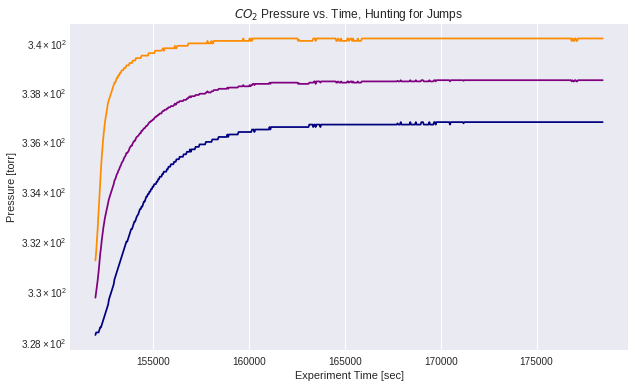

In [6]:
checked_bounds = [152001, 178450]
CO2_jump_table = gas_tables[4][gas_tables[4]['exp_time'].between(checked_bounds[0], checked_bounds[1])]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(CO2_jump_table['exp_time'], CO2_jump_table['ch1_lerp'], color='navy')
ax.plot(CO2_jump_table['exp_time'], CO2_jump_table['mean_temp'], color='purple')
ax.plot(CO2_jump_table['exp_time'], CO2_jump_table['ch2_lerp'], color='darkorange')

ax.set_title('$CO_2$ Pressure vs. Time, Hunting for Jumps')
ax.set_xlabel('Experiment Time [sec]')
ax.set_ylabel('Pressure [torr]')
ax.set_yscale('log')

plt.show()

As the bounds of a given jump are found, place them into a nested list.

In [7]:
jump_bounds = [[51100, 64450], [64451, 89820], [89821, 110150], [110151, 152000], [152001, 178450]]

Note that since data is taken once every 41 or 42 seconds, double-counting data points would be very unlikely; however, just to be sure, I had each jump start "one second" after the previous one.

### Jump-Fitting Example: CO2 Jump 4
Jump 4 of the $CO_2$ pressure data has a long enough fall time to make it the best jump in the dataset to fit. We'll build up the analysis of it first and then generalize.

#### Extract Jump Data from Gas Table
We can use the `between` function from Pandas series to extract the experiment time, top temperature, and pressure from the jump.

In [8]:
CO2_jump4_table = gas_tables[4][gas_tables[4]['exp_time'].between(jump_bounds[3][0], jump_bounds[3][1])].reset_index(drop=True)
CO2_jump4_table

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp
0,110177.0,9.550000e-08,319.7,321.7,320.70
1,110219.0,9.610000e-08,319.7,321.9,320.80
2,110260.0,9.610000e-08,319.7,322.3,321.00
3,110302.0,9.540000e-08,319.8,322.9,321.35
4,110343.0,9.730000e-08,319.8,323.4,321.60
...,...,...,...,...,...
1004,151794.0,7.040000e-08,328.3,330.9,329.60
1005,151835.0,7.030000e-08,328.4,331.0,329.70
1006,151877.0,7.090000e-08,328.4,331.0,329.70
1007,151918.0,7.130000e-08,328.3,331.0,329.65


We need the time to be shifted so that the first data point is the start time of the jump. We do this by finding the smallest value of `exp_time` and subtracting it.

In [9]:
CO2_jump4_table['exp_time'].min()

110177.0

In [10]:
CO2_jump4_table['jump_time'] = CO2_jump4_table['exp_time'] - CO2_jump4_table['exp_time'].min()
CO2_jump4_table

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp,jump_time
0,110177.0,9.550000e-08,319.7,321.7,320.70,0.0
1,110219.0,9.610000e-08,319.7,321.9,320.80,42.0
2,110260.0,9.610000e-08,319.7,322.3,321.00,83.0
3,110302.0,9.540000e-08,319.8,322.9,321.35,125.0
4,110343.0,9.730000e-08,319.8,323.4,321.60,166.0
...,...,...,...,...,...,...
1004,151794.0,7.040000e-08,328.3,330.9,329.60,41617.0
1005,151835.0,7.030000e-08,328.4,331.0,329.70,41658.0
1006,151877.0,7.090000e-08,328.4,331.0,329.70,41700.0
1007,151918.0,7.130000e-08,328.3,331.0,329.65,41741.0


#### Getting the Pressure Fit Inputs
The fitting function will need the time and temperature data (`tT`) as a numpy array of shape `(2,M)` and the observed pressure data `press_obs` as a numpy array of shape `(M,)`.

In [11]:
CO2_jump4_tT = CO2_jump4_table[['jump_time', 'ch1_lerp']].T.to_numpy() # we're using the top temperature channel for now
CO2_jump4_press_obs = CO2_jump4_table['pressure'].to_numpy()

print('tT shape: {}\nPressure shape: {}'.format(CO2_jump4_tT.shape, CO2_jump4_press_obs.shape))

tT shape: (2, 1009)
Pressure shape: (1009,)


#### Optimization
We can now optimize over these inputs. The initial parameter guess will be based on previous fits.

In [12]:
init_params = [7, 1900, 0.005]

In [13]:
CO2_jump4_fit = spo.curve_fit(pressure_fit, CO2_jump4_tT, CO2_jump4_press_obs, p0=init_params, maxfev=100000)

In [14]:
CO2_jump4_fit[0]

array([6.84206216e-03, 3.56752169e+03, 7.99499443e-01])

#### Generate Predicted Values
We can calculate the pressure fits with a regular function call using the fit values.

In [15]:
CO2_jump4_pred = pressure_fit(CO2_jump4_tT, *CO2_jump4_fit[0])

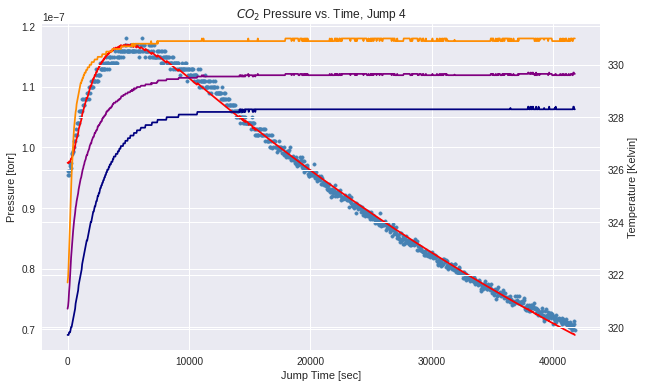

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4_tT[0], CO2_jump4_press_obs, marker='.', color='steelblue')
ax.plot(CO2_jump4_tT[0], CO2_jump4_pred, color='red')

ax2 = ax.twinx()
ax2.plot(CO2_jump4_tT[0], CO2_jump4_table['ch2_lerp'], color='darkorange')
ax2.plot(CO2_jump4_tT[0], CO2_jump4_table['mean_temp'], color='purple')
ax2.plot(CO2_jump4_tT[0], CO2_jump4_tT[1], color='navy')
ax2.set_ylabel('Temperature [Kelvin]')

ax.set_title('$CO_2$ Pressure vs. Time, Jump 4')
ax.set_xlabel('Jump Time [sec]')
ax.set_ylabel('Pressure [torr]')
#ax.set_yscale('log')

plt.show()

Here is the corresponding residual plot.

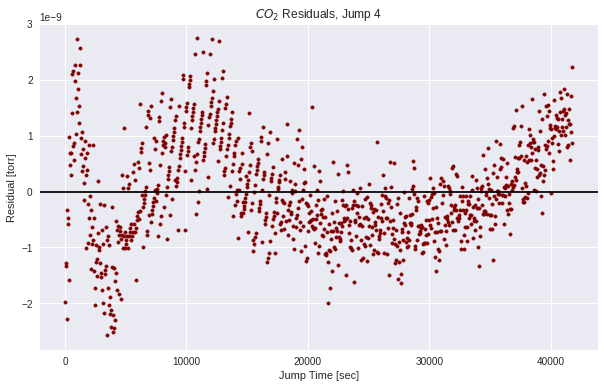

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4_tT[0], CO2_jump4_press_obs-CO2_jump4_pred, marker='.', color='maroon')
ax.axhline(color='k')

ax.set_title('$CO_2$ Residuals, Jump 4')
ax.set_xlabel('Jump Time [sec]')
ax.set_ylabel('Residual [torr]')

plt.show()

#### Single-Jump $\chi^2$ Scan
For now, we set the bounds of the scan to be $\pm5\%$ for $b$, and $\pm10\%$ for $c$.

In [18]:
scan_center = (3.56752169e+03, 7.99499443e-01) # scan center (b, c)
scan_b_bounds = [0.995*scan_center[0], 1.005*scan_center[0]]
scan_c_bounds = [0.95*scan_center[1], 1.05*scan_center[1]]

For the scan, we need to be able to pressure fit for a fixed pair $(b, c)$, so we'll use the `lambda` function. First, we check that this works for a singe pair.

In [19]:
# single pair fixed (b, c) fitting
single_fixed_fit = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, scan_center[0], scan_center[1]), CO2_jump4_tT, CO2_jump4_press_obs, p0=init_params[0], maxfev=100000)
single_fixed_fit[0] # same result?

array([0.00684206])

The syntax seems to work beause we got the same answer for the parameter $A$. Now let's generalize to a $75\times 75$ scan.

In [20]:
scan_b_points = np.linspace(scan_b_bounds[0], scan_b_bounds[1], num=75)
scan_c_points = np.linspace(scan_c_bounds[0], scan_c_bounds[1], num=75)

In [21]:
chi_sq = np.zeros((scan_b_points.shape[0], scan_c_points.shape[0]))
pressure_err = 1e-9 # eyeballed from the residual plot

for x, b in enumerate(scan_b_points):
    for y, c in enumerate(scan_c_points):
        scan_point_fit = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, b, c), CO2_jump4_tT, CO2_jump4_press_obs, p0=init_params[0], maxfev=100000)
        # calculate predicted pressures
        preds = pressure_fit(CO2_jump4_tT, scan_point_fit[0][0], b, c)
        resids = CO2_jump4_press_obs - preds
        chi_square_stat = np.dot(resids, resids)/(pressure_err**2)/CO2_jump4_press_obs.shape[0]
        
        chi_sq[x, y] = chi_square_stat

In [22]:
#pd.DataFrame(chi_sq)

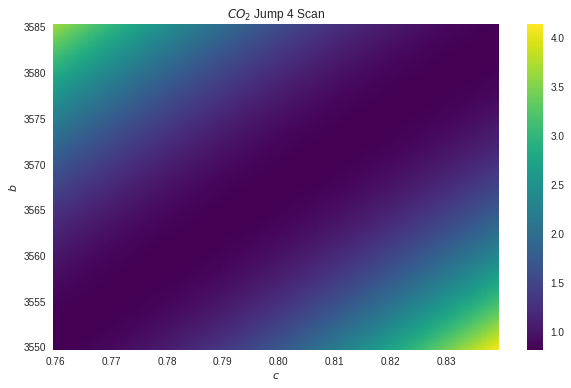

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
CO2_jump4_heat = ax.pcolormesh(scan_c_points, scan_b_points, chi_sq, cmap='viridis', shading='gouraud')

ax.set_title('$CO_2$ Jump 4 Scan')
ax.set_xlabel('$c$')
ax.set_ylabel('$b$')
plt.colorbar(CO2_jump4_heat)

plt.show()